# Machine learning digit-recognizer

In this notebook, we are going to create an algorithm which will predict the digit on a photo. This algorithm well learn from train dataset and then it will predict the digit displayed in each image of the test dataset. 

The plan to do that is the following one :

1. Exploration of data
2. Cross validation testing of the model
3. Prediction on test data
4. Submission on kaggle

Usually, neural networks are good for perception related tasks so we will use it as first model.

## Imports and useful functions

In [ ]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

import os
import pandas as pd
import matplotlib
import pydot

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

import numpy as np
import sklearn
import seaborn as sns

from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.utils import np_utils

from IPython.display import display

In [ ]:
#path of datasets
path_train = os.path.join(os.path.dirname(os.path.abspath('__file__')), 'datasets/train.csv')
path_test = os.path.join(os.path.dirname(os.path.abspath('__file__')), 'datasets/test.csv')
path_gender = os.path.join(os.path.dirname(os.path.abspath('__file__')), 'datasets/gender_submission.csv')

## 1. Exploration of data

#### *Let's begin by printing a preview of the dataset and look at its size and what it contains:*

In [20]:
#create dataframe for training dataset and print 5 first rows as preview
train_df_raw = pd.read_csv(path_train)
print('Number of rows: {0} \nNumber of columns: {1}'.format(train_df_raw.shape[0], train_df_raw.shape[1]))
print('\nPreview of the dataset:\n')
train_df_raw.head()

Number of rows: 42000 
Number of columns: 785

Preview of the dataset:



,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
# print infos about the dataset
train_df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB


In [22]:
train_df_raw.describe()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
count,42000.000000,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,...,42000.000000,42000.000000,42000.000000,42000.00000,42000.000000,42000.000000,42000.0,42000.0,42000.0,42000.0
mean,4.456643,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.219286,0.117095,0.059024,0.02019,0.017238,0.002857,0.0,0.0,0.0,0.0
std,2.887730,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.312890,4.633819,3.274488,1.75987,1.894498,0.414264,0.0,0.0,0.0,0.0
min,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,4.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
75%,7.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
max,9.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,254.000000,254.000000,253.000000,253.00000,254.000000,62.000000,0.0,0.0,0.0,0.0


In [23]:
# Check if there are missing datas
train_df_raw.isnull().values.any()
train_df_raw.isna().values.any()

False

#### *From this first preview and according to information from kaggle, it seems that each image contains 784 pixels (28x28 pixels), each pixel contain a value between 0 and 254 reprensenting the gray level of this pixel. There is no missing values. Let's try to display the first 10 images from the values of the dataset:*

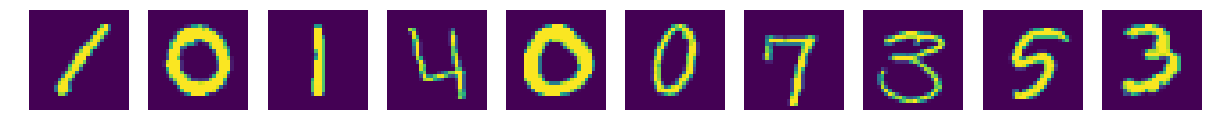

In [24]:
def dislay_images_from_pixels(nb): 
    images = [np.array(train_df_raw.drop(['label'], 1).iloc[i].tolist()).reshape(28, 28) for i in range (nb)]

    fig, plots = plt.subplots(1, nb)
    fig.set_size_inches(21, 10)
    for n in range(nb):
        plots[n].imshow(images[n])
        plots[n].axis('off')
        
dislay_images_from_pixels(10)

#### *For a human being, it simple to recognize the digit on those images but is it for a machine ? let's try to do it with machine learning*

## 2. Cross validation testing of the model

In [25]:
train_df = train_df_raw.copy()

# Let's divide the train dataset in two datasets to evaluate perfomance of machine learning models used
X_train = train_df.drop(['label'], 1)
Y_train = train_df['label']


# Split dataset for prediction
X_train_sample_train, X_train_sample_test, Y_train_sample_train, Y_train_sample_test = train_test_split(X_train, Y_train, test_size=0.5, random_state=42)


# Format data to pass to keras CNN model
X_train_sample_train = X_train_sample_train.values.reshape(X_train_sample_train.shape[0], 28, 28, 1).astype('float32') / 255
X_train_sample_test = X_train_sample_test.values.reshape(X_train_sample_test.shape[0], 28, 28, 1).astype('float32') / 255
X_train = X_train.values.reshape(X_train.shape[0], 28, 28, 1).astype('float32') / 255

# Convert labels to categorical one-hot encoding
Y_train_sample_train = np_utils.to_categorical(Y_train_sample_train, 10)
Y_train_sample_test = np_utils.to_categorical(Y_train_sample_test, 10)
Y_train = np_utils.to_categorical(Y_train, 10)

#### *Let's create our CNN arhitecture ! I'm going to use this notebook to make my choice of which layers to use :*
#### https://www.kaggle.com/cdeotte/how-to-choose-cnn-architecture-mnist

In [26]:
# Create keras model and add it layers
model = Sequential()

model.add(Conv2D(32,kernel_size=3,activation='relu',input_shape=(28,28,1)))
model.add(BatchNormalization())
model.add(Conv2D(32,kernel_size=3,activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(32,kernel_size=5,strides=2,padding='same',activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv2D(64,kernel_size=3,activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64,kernel_size=3,activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64,kernel_size=5,strides=2,padding='same',activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(10, activation='softmax'))

In [27]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [25]:
model.fit(X_train_sample_train, Y_train_sample_train, batch_size=32, nb_epoch=10, verbose=1)

Epoch 1/10
21000/21000 [==============================] - 219s 10ms/step - loss: 0.3582 - acc: 0.8909
Epoch 2/10
21000/21000 [==============================] - 202s 10ms/step - loss: 0.1081 - acc: 0.9674
Epoch 3/10
21000/21000 [==============================] - 180s 9ms/step - loss: 0.0818 - acc: 0.9747
Epoch 4/10
21000/21000 [==============================] - 178s 8ms/step - loss: 0.0701 - acc: 0.9785
Epoch 5/10
21000/21000 [==============================] - 185s 9ms/step - loss: 0.0603 - acc: 0.9816
Epoch 6/10
21000/21000 [==============================] - 201s 10ms/step - loss: 0.0530 - acc: 0.9841
Epoch 7/10
21000/21000 [==============================] - 221s 11ms/step - loss: 0.0451 - acc: 0.9852
Epoch 9/10
21000/21000 [==============================] - 224s 11ms/step - loss: 0.0464 - acc: 0.9858
Epoch 10/10
21000/21000 [==============================] - 262s 12ms/step - loss: 0.0439 - acc: 0.9860


In [26]:
score = model.evaluate(X_train_sample_test, Y_train_sample_test, verbose=0)
print(score[1])

0.9898571428571429


## 3. Prediction on test data

In [28]:
X_test = pd.read_csv(path_test)
X_test = X_test.values.reshape(X_test.shape[0], 28, 28, 1).astype('float32') / 255

In [ ]:
model.fit(X_train, Y_train, batch_size=32, nb_epoch=10, verbose=1)
predict_result = model.predict_classes(X_test, verbose=0)

Epoch 1/10
42000/42000 [==============================] - 386s 9ms/step - loss: 0.2216 - acc: 0.9330
Epoch 2/10
42000/42000 [==============================] - 353s 8ms/step - loss: 0.0724 - acc: 0.9782
Epoch 3/10
42000/42000 [==============================] - 345s 8ms/step - loss: 0.0632 - acc: 0.9807
Epoch 4/10
42000/42000 [==============================] - 379s 9ms/step - loss: 0.0522 - acc: 0.9842
Epoch 5/10
42000/42000 [==============================] - 358s 9ms/step - loss: 0.0485 - acc: 0.9856
Epoch 6/10
42000/42000 [==============================] - 355s 8ms/step - loss: 0.0432 - acc: 0.9873
Epoch 7/10
42000/42000 [==============================] - 479s 11ms/step - loss: 0.0391 - acc: 0.9880
Epoch 8/10
42000/42000 [==============================] - 425s 10ms/step - loss: 0.0304 - acc: 0.9907
Epoch 10/10
30304/42000 [====================>.........] - ETA: 1:52 - loss: 0.0263 - acc: 0.9913

## 4. Submission on kaggle

In [31]:
predict_result = model.predict_classes(X_test, verbose=0)
submission = pd.DataFrame({"ImageId": list(range(1,len(predict_result)+1)),
                         "Label": predict_result})
submission.to_csv("submission_keras.csv", index=False, header=True)

#### Final score : 0.99457